In [28]:
ion1 = -2
ion2 = 3
nions = 13
nseg = 25

new_file_suffix = "v2"  # new filename will be  <date>_am_<nions>_<new_file_suffix>.json
prev_solution_file = "../out/20260205_am_13_v1.json"  # previous solution to use as initial guess

params_file = "../system_params/072125_goldparams_13ions.json"

"../system_params/072125_goldparams_13ions.json"

In [29]:
using GoldGates
using MSSim: Optimizers as Opts, SegSeq as SS, SymLinear as SL, Sequence as Seq, Utils as U
using NLopt
using Statistics
using PyPlot
using JSON
using Dates

include("../src/utils.jl")
ENV["MPLBACKEND"] = "module://matplotlib_inline.backend_inline"

sysparams = open(params_file) do io
    read(io, GoldGates.SystemParams; format=:json)
end

date = Dates.format(Dates.now(), "yyyymmdd")
out_file = "../out/$(date)_am_$(nions)_$(new_file_suffix).json"

# === Load previous solution metadata ===
prev_ion_pair_key = join(sort([ion1, ion2], rev=true), ",")
prev_meta = load_solution_metadata(prev_solution_file, prev_ion_pair_key)
if prev_meta === nothing
    error("No metadata found for $prev_ion_pair_key in $prev_solution_file")
end

prev_params = get(prev_meta, "opt_params", nothing)
if prev_params === nothing
    error("No opt_params found in previous solution. Cannot do warm-start.")
end

# Optimizer settings from previous solution
pitime = prev_meta["pitime"]
τmin = prev_meta["τmin"]
τmax = prev_meta["τmax"]
maxtime = prev_meta["maxtime"]
min_mode_index = Int(prev_meta["min_mode_index"])
max_mode_index = Int(prev_meta["max_mode_index"])
println("Previous optimizer config: pitime=$pitime, τ=[$τmin, $τmax], modes=[$min_mode_index, $max_mode_index]")

Previous optimizer config: pitime=8, τ=[5, 15], modes=[1, 2]


(obj = 2.1634160677570644e-5, dis = 8.481338364810202e-9, disδ = 0.001982915192601302, area = -1.5707962528039814, areaε = -7.399091517257261e-8, areaδ = -13.276300359166397, total_t = 328.5059164769847, Ωmax = 0.0)
(obj = 2.1634160647318622e-5, dis = 8.481463685365652e-9, disδ = 0.0019829152324382124, area = -1.570796252469916, areaε = -7.432498061454851e-8, areaδ = -13.276296366417085, total_t = 328.50591421401407, Ωmax = 0.0)
(obj = 5.6659267970446835e-6, dis = 3.460892703445586e-9, disδ = 0.0003718541580014718, area = -1.5707963026151521, areaε = -2.4179744428920458e-8, areaδ = -13.892734414242339, total_t = 328.79900470205627, Ωmax = 9.250584366864373e-6)
(obj = 5.665926792400637e-6, dis = 3.4608776142969064e-9, disδ = 0.0003718541646537234, area = -1.5707963024297908, areaε = -2.436510571079964e-8, areaδ = -13.89273442640462, total_t = 328.79900472154344, Ωmax = 9.250556444121498e-6)
  0.478352 seconds (72.65 k allocations: 5.199 MiB)
{
    "pitime": 8,
    "displacement_at_-1kHz

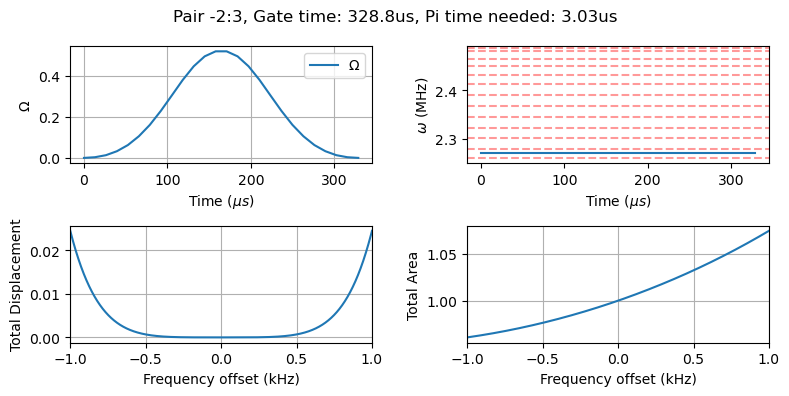

In [32]:
# === Build model & optimizer using previous solution's config ===
modes = setup_modes(sysparams, ion1, ion2, nions)
nlmodel = setup_model(nseg, modes)
opt, tracker = setup_optimizer(nlmodel, sysparams; pitime, τmin, τmax, maxtime, min_mode_index, max_mode_index)

# === Optimize (warm start from previous solution) ===
best_params, best_obj = run_optimization!(opt, tracker, nlmodel;
    initial_params=prev_params, perturbation=0.05)

# === Review results & save ===
opt_raw_params, metadata = get_metadata_and_plot(nlmodel, best_params, nseg, sysparams, modes;
    ion1, ion2, pitime, τmin, τmax, maxtime, min_mode_index, max_mode_index)
println(JSON.json(metadata, 4))
save_am_solution(out_file, opt_raw_params, metadata, sysparams, ion1, ion2)